In [1]:
import pandas as pd
from urllib.request import Request, urlopen
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import re
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
pd.set_option('display.max_rows', None)

In [2]:
df=pd.read_csv('../processed_data/price_df_10mins_furtherpreprocess_24hvol.csv')
df['tx_timestamp'] = pd.to_datetime(df['tx_timestamp'],unit='ns')
df = df.rename(columns = {"tx_timestamp":"timestamp","0":"volatility"})
display(df.head(3))
df.tail()
df = df.set_index('timestamp')
vol_df =df['24rolling_vol']*np.sqrt(365)

,Unnamed: 0,timestamp,first,last,mean,vol_of_vol,max,min,ret,24rolling_vol
0,0,2020-05-26 21:00:00+00:00,201.177211,201.177211,201.0,NaN,201.177211,201.177211,0.0,NaN
1,1,2020-05-26 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-05-26 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
aave_df=pd.read_csv('../processed_data/aave_10mins_activities.csv')
aave_df=aave_df.rename(columns={"tx_timestamp":"timestamp"})
aave_df=aave_df.set_index("timestamp")
aave_df.index = pd.to_datetime(aave_df.index)

In [5]:
aave_df['usdt_deposit']=np.log(aave_df['usdt_deposit']+1)
aave_df['usdt_withdraw']=np.log(aave_df['usdt_withdraw']+1)
aave_df['usdt_borrow']=np.log(aave_df['usdt_borrow']+1)
aave_df['usdt_repay']=np.log(aave_df['usdt_repay']+1)
aave_df['eth_deposit']=np.log(aave_df['eth_deposit']+1)
aave_df['eth_withdraw']=np.log(aave_df['eth_withdraw']+1)
aave_df['eth_borrow']=np.log(aave_df['eth_borrow']+1)
aave_df['eth_repay']=np.log(aave_df['eth_repay']+1)
aave_df.head()

,usdt_deposit,usdt_withdraw,usdt_borrow,usdt_repay,eth_deposit,eth_withdraw,eth_borrow,eth_repay
timestamp,,,,,,,,
2020-12-01 15:30:00+00:00,0.0,0.0,0.0,0.0,34.538776,0.000000,0.0,0.0
2020-12-01 15:40:00+00:00,0.0,0.0,0.0,0.0,0.000000,34.538776,0.0,0.0
2020-12-01 15:50:00+00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2020-12-01 16:00:00+00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2020-12-01 16:10:00+00:00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [6]:
volume_df = pd.read_csv('../processed_data/volume.csv')
volume_df['tx_timestamp'] = pd.to_datetime(volume_df['tx_timestamp'],unit='ns')
volume_df = volume_df.rename(columns = {"tx_timestamp":"timestamp","0":"volatility"})
volume_df = volume_df.set_index('timestamp')
volume_df['Amount1_volume']=np.log(volume_df['Amount1_volume'].astype(float)+1)
volume_df['Amount0_volume']=np.log(volume_df['Amount0_volume'].astype(float)+1)
volume_df.head()

,Amount1_volume,Amount0_volume
timestamp,,
2020-05-26 21:00:00+00:00,16.865438,39.192273
2020-05-26 21:10:00+00:00,0.000000,0.000000
2020-05-26 21:20:00+00:00,0.000000,0.000000
2020-05-26 21:30:00+00:00,0.000000,0.000000
2020-05-26 21:40:00+00:00,0.000000,0.000000


<AxesSubplot: xlabel='timestamp'>

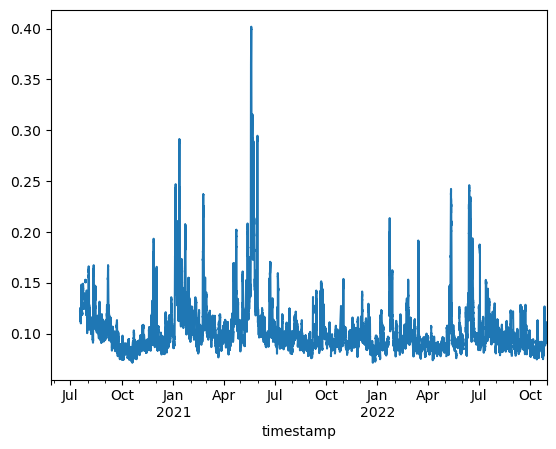

In [7]:
vol_df.plot()

In [8]:
vol_df.min()

0.07145312882840953

In [9]:
vol_df = vol_df.fillna(method= 'ffill')

In [10]:
vol_df.max()

0.4018414022471649

In [11]:
df_price = df.iloc[:,1:-2]
df_price = df_price.drop(columns = 'vol_of_vol')

In [12]:
df_price.head()

,first,last,mean,max,min
timestamp,,,,,
2020-05-26 21:00:00+00:00,201.177211,201.177211,201.0,201.177211,201.177211
2020-05-26 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-05-26 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-05-26 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-05-26 21:40:00+00:00,NaN,NaN,NaN,NaN,NaN


In [13]:
#df_final  = pd.concat([df_price,volume_df,vol_df,aave_df],axis =1)
df_final  = pd.concat([vol_df,aave_df],axis =1)

In [14]:
df_final.head()

,24rolling_vol,usdt_deposit,usdt_withdraw,usdt_borrow,usdt_repay,eth_deposit,eth_withdraw,eth_borrow,eth_repay
timestamp,,,,,,,,,
2020-05-26 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-26 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-26 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-26 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-26 21:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df = df_final
df = df.fillna(method = 'ffill')
df = df.fillna(0)

In [16]:
df.head()

,24rolling_vol,usdt_deposit,usdt_withdraw,usdt_borrow,usdt_repay,eth_deposit,eth_withdraw,eth_borrow,eth_repay
timestamp,,,,,,,,,
2020-05-26 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:40:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df.tail()


,24rolling_vol,usdt_deposit,usdt_withdraw,usdt_borrow,usdt_repay,eth_deposit,eth_withdraw,eth_borrow,eth_repay
timestamp,,,,,,,,,
2022-10-30 13:50:00+00:00,0.091792,0.000000,0.0,0.0,0.0,0.000000,43.472721,46.051702,0.0
2022-10-30 14:00:00+00:00,0.091673,0.000000,0.0,0.0,0.0,43.525973,0.000000,0.000000,0.0
2022-10-30 14:10:00+00:00,0.091597,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2022-10-30 14:20:00+00:00,0.092790,19.062535,0.0,0.0,0.0,43.951093,0.000000,0.000000,0.0
2022-10-30 14:30:00+00:00,0.092494,19.062535,0.0,0.0,0.0,43.951093,0.000000,0.000000,0.0


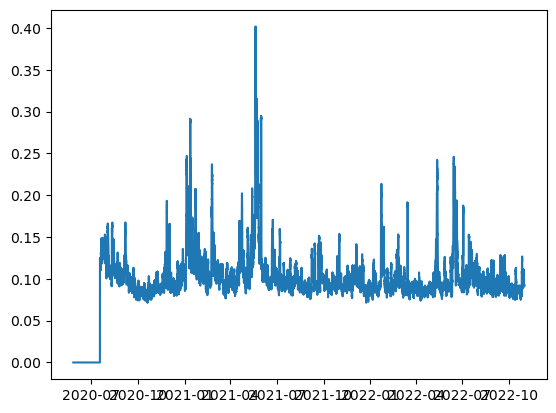

In [18]:
plt.plot(df.index,df['24rolling_vol'])

In [19]:
df.shape

(127690, 9)

In [20]:
train_start = '2020-12-01'
train_end = '2022-07-31'
dev_start = '2022-08-01'
dev_end = '2022-09-30'
test_start = '2022-10-01'
test_end = '2022-10-31'

In [21]:
df = df.iloc[:,:-1]

In [22]:
df.head()

,24rolling_vol,usdt_deposit,usdt_withdraw,usdt_borrow,usdt_repay,eth_deposit,eth_withdraw,eth_borrow
timestamp,,,,,,,,
2020-05-26 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-26 21:40:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
train_dates = df[((df.index >= train_start) & (df.index <= train_end))].values
dev_dates = df[((df.index >= dev_start) & (df.index <= dev_end))].values
test_dates = df[((df.index >= test_start) & (df.index <= test_end))].values
train_dates.shape, dev_dates.shape, test_dates.shape

((87409, 8), (8641, 8), (4264, 8))

In [24]:
train_y =  vol_df.fillna(method = 'ffill')[((vol_df.index >= train_start) & (vol_df.index <= train_end))].values
dev_y =  vol_df.fillna(method='ffill')[((vol_df.index >= dev_start) & (vol_df.index <= dev_end))].values
test_y =  vol_df.fillna(method='ffill')[((vol_df.index >= test_start) & (vol_df.index <= test_end))].values

In [25]:
#https://www.section.io/engineering-education/univariate-time-series-using-recurrent-neural-networks/
#from sklearn.preprocessing import MinMaxScaler
# since it's the price we will scale it
scaler = MinMaxScaler()
scaler.fit(train_dates)
scaler.fit(dev_dates)
scaler.fit(test_dates)

scaled_train_dates = scaler.transform(train_dates)
scaled_dev_dates = scaler.transform(dev_dates)
scaled_test_dates = scaler.transform(test_dates)

In [26]:
scaled_train_dates

array([[0.61473315, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.58620954, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.58719415, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40323473, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.36391575, 0.        , 0.        , ..., 0.62767327, 0.        ,
        0.        ],
       [0.37027985, 0.        , 0.        , ..., 0.        , 0.        ,
        0.86613862]])

In [26]:
train_y

array([0.10671643, 0.10523057, 0.10528186, ..., 0.09569899, 0.09365078,
       0.0939823 ])

In [27]:
from keras.preprocessing.sequence import TimeseriesGenerator
days_look_back = 2
n_input = 24*6*days_look_back
n_features = 9
train_data_gen = TimeseriesGenerator(scaled_train_dates  , train_y  ,length=n_input, batch_size=64)
dev_data_gen = TimeseriesGenerator(scaled_dev_dates, dev_y,length=n_input, batch_size=64)

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
adam = Adam(lr=0.0001, clipnorm=1.0, clipvalue=0.5)
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(n_input,n_features)))


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
early_stopping = EarlyStopping(monitor = 'loss', patience=2, min_delta=1e-8)
adam = Adam(lr=0.0001, clipnorm=1.0, clipvalue=0.5)
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=adam, loss=tf.keras.losses.MeanSquaredLogarithmicError())

num_epochs = 100

history = model.fit(train_data_gen, epochs=num_epochs)

In [ ]:
model.summary()

In [ ]:
model_save_name = 'lstm64_dense_volaave'
model.save('model_{}.h5'.format(model_save_name))

In [ ]:
#import tensorflow as tf
#from tensorflow import keras

# Check its architecture
model.summary()

In [ ]:
model.evaluate_generator(dev_data_gen)
trainPredict = model.predict_generator(train_data_gen)
devPredict = model.predict_generator(dev_data_gen)
testPredict = model.predict_generator(test_data_gen)

In [ ]:
len(devPredict)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(devPredict, dev_y[24*6*days_look_back:])

In [ ]:
mean_absolute_percentage_error(trainPredict, train_y[24*6*days_look_back:])

In [ ]:
plt.plot(dev_y)

In [ ]:
trainPredict

In [ ]:
plt.plot(devPredict)

In [ ]:
plt.plot(devPredict)
plt.plot(dev_y[24*6*days_look_back:])

In [ ]:
plt.figure()
plt.plot(trainPredict)
#plt.plot(train_y)

In [ ]:
train_y[24*6*days_look_back:]

In [ ]:
plt.plot(train_y)

In [ ]:
tmp = vol_df
tmp[tmp>0.1]=np.nan

In [ ]:
plt.plot(tmp.fillna(method='ffill'))

In [ ]:
trainPredict_baseline = baseline_model.predict_generator(train_y.reshape(-1,1))
devPredict_baseline  = baseline_model.predict_generator(dev_y.reshape(-1,1))

In [ ]:
days_look_back = 2
n_input = 24*6*days_look_back
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(trainPredict_baseline, train_y)

In [ ]:
tmp = trainPredict_baseline
tmp